# Sales Analysis

**Author:** Francisco Escobar Rivas  


## Dataset Description
**File:** `AusApparalSales4thQrt2020.csv`  
**Time Coverage:** Q4 2020  
**Grain:** Transaction-level record (row = sale/event) *(assumed; adjust if different)*  
**Expected Columns:** State, demographic group (Kids/Women/Men/Seniors), date/time, units, sales, etc.

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
data_path = "./AusApparalSales4thQrt2020.csv"

In [44]:
data = pd.read_csv(data_path)

#### First Five Rlements

In [45]:
data.head()

,Date,Time,State,Group,Unit,Sales
0,1-Oct-2020,Morning,WA,Kids,8,20000
1,1-Oct-2020,Morning,WA,Men,8,20000
2,1-Oct-2020,Morning,WA,Women,4,10000
3,1-Oct-2020,Morning,WA,Seniors,15,37500
4,1-Oct-2020,Afternoon,WA,Kids,3,7500


#### Last Five Elements

In [46]:
data.tail()

,Date,Time,State,Group,Unit,Sales
7555,30-Dec-2020,Afternoon,TAS,Seniors,14,35000
7556,30-Dec-2020,Evening,TAS,Kids,15,37500
7557,30-Dec-2020,Evening,TAS,Men,15,37500
7558,30-Dec-2020,Evening,TAS,Women,11,27500
7559,30-Dec-2020,Evening,TAS,Seniors,13,32500


#### Information of Dataframe

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    7560 non-null   object
 1   Time    7560 non-null   object
 2   State   7560 non-null   object
 3   Group   7560 non-null   object
 4   Unit    7560 non-null   int64 
 5   Sales   7560 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 354.5+ KB


## General Methodology

### 1. Data Wrangling

#### 1.1 Data Quality Audit
- a) Inspection of null values (`isna` / `notna`)  

- b) Detection of inconsistencies and duplicates  

##### a) Inspection of null values (`isna` / `notna`)  

In [48]:
na_values = data.isna().sum()
print("Not a number values per Column:")
print(na_values)

Not a number values per Column:
Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64


In [49]:
missing_values = data.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64


##### There is Null values or NaN values on this data set

##### b) Detection of inconsistencies and duplicates  

In [50]:
n_before = len(data)
data.drop_duplicates(inplace=True) 
n_removed = n_before - len(data)
print(f"There is {n_removed} rows duplicates")

There is 0 rows duplicates


#### 1.2 Missing/Incorrect Data Treatment Criteria
- a) Deletion vs. imputation (recommendation)

While there aren't null values and duplicates rows, the data doesn't need a deletion or inputation.

#### 1.3 Normalization/Standardization
- a) Chosen method (normalization)

- b) Resulting data (summary view)

#### a) Chosen method (normalization)

<Axes: ylabel='Frequency'>

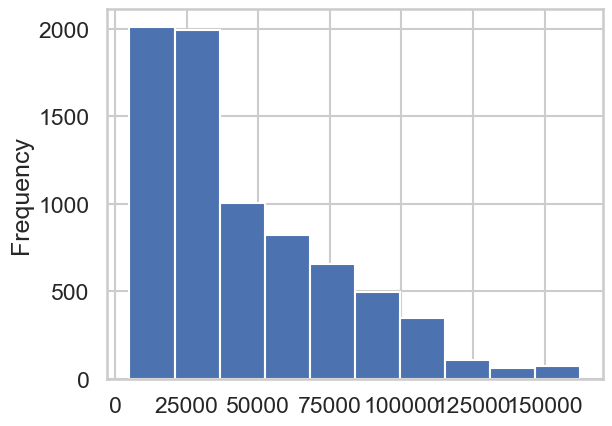

In [51]:
data["Sales"].plot(kind='hist')

<Axes: ylabel='Frequency'>

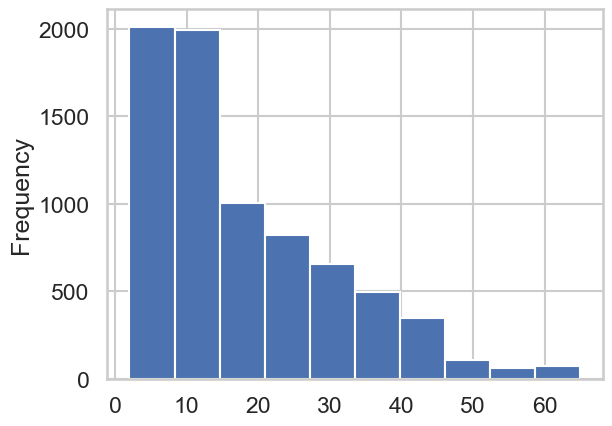

In [52]:
data["Unit"].plot(kind='hist')

Given the pronounced right-hand tails for Sales and Unit we need to apply another to normalize the data.


In [ ]:


target_cols = [c for c in ["Sales", "Unit"] if c in data.columns]
if not target_cols:
    raise ValueError("Expected 'Sales' and/or 'Unit' columns in the dataset.")


for col in target_cols:
    data[col] = pd.to_numeric(data[col], errors="coerce")


def iqr_outlier_rate(s: pd.Series, k: float = 1.5) -> float:

    x = pd.to_numeric(s, errors="coerce").dropna()
    if x.empty:
        return 0.0
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return float(((x < lower) | (x > upper)).mean())

def quantile_lower(s: pd.Series, p: float) -> float:

    x = pd.to_numeric(s, errors="coerce").dropna()
    if x.empty:
        return np.nan
    try:

        return float(x.quantile(p, interpolation="lower"))
    except TypeError:

        arr = np.sort(x.to_numpy())
        n = arr.size
        idx = int(np.floor(p * (n - 1)))
        if idx >= n:  
            idx = n - 1

        if idx == n - 1 and n > 1:
            idx = n - 2
        return float(arr[idx])

def minmax01(s: pd.Series) -> pd.Series:

    x = pd.to_numeric(s, errors="coerce")
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn) if pd.notna(mn) and pd.notna(mx) and mx != mn else pd.Series(0.0, index=x.index)

def try_clip_then_metrics(s: pd.Series, p: float):

    thr = quantile_lower(s, p)
    w = s.clip(upper=thr)
    changed = int((w != s).sum())
    out_b = iqr_outlier_rate(s) * 100.0
    out_a = iqr_outlier_rate(w) * 100.0
    skew_b = float(s.skew())
    skew_a = float(w.skew())
    range_ok = bool(w.max() >= w.min())
    metrics = {
        "p": p,
        "threshold": float(thr),
        "changed_rows": changed,
        "outliers_before_pct": round(out_b, 3),
        "outliers_after_pct": round(out_a, 3),
        "skew_before": round(skew_b, 4),
        "skew_after": round(skew_a, 4),
        "range_ok": range_ok,
    }
    return w, metrics

def method_passes(m: dict,
                  require_change=True,
                  allow_equal_outliers=False,
                  max_after_outliers_pct=1.0,
                  require_skew_not_worse=True) -> bool:

    conds = []
    if require_change:
        conds.append(m["changed_rows"] > 0)
    if allow_equal_outliers:
        conds.append(m["outliers_after_pct"] <= m["outliers_before_pct"])
    else:
        conds.append(m["outliers_after_pct"] < m["outliers_before_pct"])
    conds.append(m["outliers_after_pct"] <= max_after_outliers_pct)
    if require_skew_not_worse:
        conds.append(m["skew_after"] <= m["skew_before"])
    conds.append(m["range_ok"])
    return all(conds)


results = []
for col in target_cols:
    s = data[col]
    chosen = None
    for p in (0.98, 0.97, 0.95):  
        w, metr = try_clip_then_metrics(s, p)
        if method_passes(metr,
                         require_change=True,
                         allow_equal_outliers=False,
                         max_after_outliers_pct=1.0,
                         require_skew_not_worse=True):
            
            data[f"{col}_w"] = w
            data[f"{col}_w_norm"] = minmax01(w)
            chosen = metr
            break
    results.append({"column": col, **(chosen or metr)})


summary = pd.DataFrame(results)



#### b) Resulting data (summary view)

In [ ]:
print(summary.to_string(index=False))


norm_cols = [c for c in data.columns if c.endswith("_w_norm")]
print("\nNormalized ranges (expect 0..1):")
print(data[norm_cols].agg(["min", "max", "mean"]).T)

column    p  threshold  changed_rows  outliers_before_pct  outliers_after_pct  skew_before  skew_after  range_ok
 Sales 0.98   125000.0           151                1.627                 0.0       1.0856      0.8962      True
  Unit 0.98       50.0           151                1.627                 0.0       1.0856      0.8962      True

Normalized ranges (expect 0..1):
              min  max      mean
Sales_w_norm  0.0  1.0  0.330029
Unit_w_norm   0.0  1.0  0.330029


In [55]:
data.head()

,Date,Time,State,Group,Unit,Sales,Sales_w,Sales_w_norm,Unit_w,Unit_w_norm
0,1-Oct-2020,Morning,WA,Kids,8,20000,20000,0.125000,8,0.125000
1,1-Oct-2020,Morning,WA,Men,8,20000,20000,0.125000,8,0.125000
2,1-Oct-2020,Morning,WA,Women,4,10000,10000,0.041667,4,0.041667
3,1-Oct-2020,Morning,WA,Seniors,15,37500,37500,0.270833,15,0.270833
4,1-Oct-2020,Afternoon,WA,Kids,3,7500,7500,0.020833,3,0.020833


### 1.4 Use of `GroupBy`
- a) Chunking vs. merging (analysis and recommendation)


#### Chunking vs. merging (analysis and recommendation)

With the data already winsorized and normalized, we need reliable rollups that answer S&M’s core questions (top/bottom states, segment performance, and time trends) and row-level KPIs to prioritize actions. We will:
- **Chunk** the data into dashboard-ready summaries (by *State*, *Group*, *State×Group*, and *Time*).
- **Merge** key aggregates back into the fact table to compute per-row KPIs (e.g., state share, lift vs. group).

> **Best practice**
> - Use **monetary columns** (e.g., `Sales_w` or `Sales`) for **sums and rankings**; this preserves business meaning.
> - Use **normalized columns** (e.g., `Sales_w_norm`) for **comparability** (means/percentiles, not sums).
> - Keep `data` as the single **base fact table**; derived views can be regenerated at any time.

In [ ]:

value_col = "Sales_w" if "Sales_w" in data.columns else "Sales"
unit_col  = "Unit_w"  if "Unit_w"  in data.columns else "Unit"
norm_col  = "Sales_w_norm" if "Sales_w_norm" in data.columns else None


required = [value_col, unit_col, "State", "Group"]
missing = [c for c in required if c not in data.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")


date_candidates = ["Date", "date", "OrderDate", "order_date"]
date_col = next((c for c in date_candidates if c in data.columns), None)
if date_col:
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")

#### Chunking A — State Ranking (Monetary Sums)

**Method:** `groupby("State").sum()` for revenue and units, then sort by revenue (descending).  
**Why:** This directly answers which states generate the highest and lowest revenues and supports budget allocation and recovery programs.

In [57]:

state_rank = (
    data.groupby("State", as_index=False)
        .agg(
            revenue=(value_col, "sum"),
            units=(unit_col, "sum"),
            rows=(value_col, "size")
        )
        .sort_values("revenue", ascending=False)
        .reset_index(drop=True)
)

print("Top 10 states by revenue:")
print(state_rank.head(10).to_string(index=False))


Top 10 states by revenue:
State   revenue  units  rows
  VIC 102465000  40986  1080
  NSW  74970000  29988  1080
   SA  58857500  23543  1080
  QLD  33417500  13367  1080
  TAS  22760000   9104  1080
   NT  22580000   9032  1080
   WA  22152500   8861  1080


#### Chunking B — State × Group Heatmaps

**Method:** Two complementary pivot tables:
- **Monetary sums** (`value_col`) to locate absolute revenue concentration across demographic groups by state.
- **Normalized means** (`Sales_w_norm`) to compare relative performance independent of scale.

**Why:** The first highlights where money is; the second reveals where performance is strong/weak relative to peers.


In [ ]:


state_group_sum = data.pivot_table(
    values=value_col, index="State", columns="Group", aggfunc="sum", fill_value=0
)


state_group_mean_norm = None
if norm_col:
    state_group_mean_norm = data.pivot_table(
        values=norm_col, index="State", columns="Group", aggfunc="mean", fill_value=0
    )

print("Heatmap (monetary sums) — shape:", state_group_sum.shape)
if state_group_mean_norm is not None:
    print("Heatmap (normalized means) — shape:", state_group_mean_norm.shape)


Heatmap (monetary sums) — shape: (7, 4)
Heatmap (normalized means) — shape: (7, 4)


#### Chunking C — Temporal Rollups (Daily/Weekly/Monthly/Quarterly)

**Method:** Extract time periods with `.dt.to_period(...)` and aggregate by `["State", period]`.  
**Why:** Trend curves by state (seasonality, peaks, and dips) inform calendarized actions (promos, staffing, inventory).


In [59]:

daily_state = weekly_state = monthly_state = quarterly_state = None

if date_col:
    data["day"]   = data[date_col].dt.date
    data["week"]  = data[date_col].dt.to_period("W").dt.start_time
    data["month"] = data[date_col].dt.to_period("M").dt.start_time
    data["qtr"]   = data[date_col].dt.to_period("Q").dt.start_time

    daily_state = (
        data.groupby(["State", "day"], as_index=False)
            .agg(revenue=(value_col, "sum"), units=(unit_col, "sum"))
            .sort_values(["State", "day"])
    )
    weekly_state = (
        data.groupby(["State", "week"], as_index=False)
            .agg(revenue=(value_col, "sum"), units=(unit_col, "sum"))
            .sort_values(["State", "week"])
    )
    monthly_state = (
        data.groupby(["State", "month"], as_index=False)
            .agg(revenue=(value_col, "sum"), units=(unit_col, "sum"))
            .sort_values(["State", "month"])
    )
    quarterly_state = (
        data.groupby(["State", "qtr"], as_index=False)
            .agg(revenue=(value_col, "sum"), units=(unit_col, "sum"))
            .sort_values(["State", "qtr"])
    )

    print("Weekly per-state sample:")
    print(weekly_state.head(10).to_string(index=False))
else:
    print("INFO: No date column detected — skipping temporal rollups.")


Weekly per-state sample:
State       week  revenue  units
  NSW 2020-09-28  3382500   1353
  NSW 2020-10-05  5892500   2357
  NSW 2020-10-12  5717500   2287
  NSW 2020-10-19  5922500   2369
  NSW 2020-10-26  4822500   1929
  NSW 2020-11-02  4915000   1966
  NSW 2020-11-09  4957500   1983
  NSW 2020-11-16  4987500   1995
  NSW 2020-11-23  5147500   2059
  NSW 2020-11-30  6277500   2511


#### Merging A — Row-Level KPI: State Share

**Method:** Sum revenue by `State`, merge back to the fact table, compute each row’s share of its state’s total.  
**Why:** Identifies high-contribution rows/segments within each state for targeted S&M actions (e.g., retention, upsell).


In [60]:

state_tot = data.groupby("State", as_index=False).agg(state_revenue=(value_col, "sum"))
data = data.merge(state_tot, on="State", how="left")

data["state_share"] = np.where(
    data["state_revenue"] > 0, data[value_col] / data["state_revenue"], np.nan
)

print("Preview with state_share KPI:")
print(data[["State", "Group", value_col, "state_revenue", "state_share"]].head(8).to_string(index=False))


Preview with state_share KPI:
State    Group  Sales_w  state_revenue  state_share
   WA     Kids    20000       22152500     0.000903
   WA      Men    20000       22152500     0.000903
   WA    Women    10000       22152500     0.000451
   WA  Seniors    37500       22152500     0.001693
   WA     Kids     7500       22152500     0.000339
   WA      Men    25000       22152500     0.001129
   WA    Women     7500       22152500     0.000339
   WA  Seniors    27500       22152500     0.001241


#### Merging B — Row-Level KPI: Lift vs. Group Average (Normalized)

**Method:** Compute the group-level mean of the normalized metric and subtract it from each row’s normalized value.  
**Why:** Flags rows/segments performing above/below their group’s norm—useful for “Next Best Offer” and hyper-personalization.


In [ ]:

if norm_col:
    grp_norm_avg = data.groupby("Group", as_index=False).agg(group_mean_norm=(norm_col, "mean"))
    data = data.merge(grp_norm_avg, on="Group", how="left")
    data["lift_vs_group"] = data[norm_col] - data["group_mean_norm"]
    print("Preview (lift vs. group):")
    print(data[["Group", norm_col, "group_mean_norm", "lift_vs_group"]].head(8).to_string(index=False))
else:
    print("INFO: No normalized column found (e.g., 'Sales_w_norm'); skipping lift KPI.")


Preview (lift vs. group):
   Group  Sales_w_norm  group_mean_norm  lift_vs_group
    Kids      0.125000         0.330688      -0.205688
     Men      0.125000         0.333146      -0.208146
   Women      0.041667         0.331382      -0.289716
 Seniors      0.270833         0.324901      -0.054067
    Kids      0.020833         0.330688      -0.309854
     Men      0.166667         0.333146      -0.166479
   Women      0.020833         0.331382      -0.310549
 Seniors      0.187500         0.324901      -0.137401


## 2. Data Analysis
### 2.1 Descriptive Statistics (Sales, Unit)




**Method**  
We compute classic descriptive statistics on the monetary and unit variables to summarize their distribution. Concretely, we: (1) coerce each series to numeric and drop missing values; (2) calculate count, mean, median, mode, and the sample standard deviation (with ddof=1); (3) extract percentiles (Q1 = 25th, Q3 = 75th) and the interquartile range (IQR = Q3−Q1); (4) present the results in a tidy table for both columns. This is exactly what your describe_numeric function does and what the desc DataFrame prints. For visualization, we complement the table with a box plot (built from the same Q1, median, Q3, and whiskers) to display spread and potential outliers at a glance.

**Why**  
These statistics provide a compact, decision-ready view of central tendency and variability while revealing distribution shape and tail behavior. Mean vs. median highlights skew (e.g., right-skew if mean > median), mode captures the most frequent purchase size, std quantifies overall dispersion, and IQR is robust to extremes—making it ideal for flagging outliers and supporting choices such as winsorization/normalization. The box plot translates percentiles and IQR into a visual that quickly exposes spread, asymmetry, and extreme values, grounding subsequent comparisons across states, groups, and time.


In [62]:
def describe_numeric(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce").dropna()
    mode_vals = s.mode()
    mode_val = float(mode_vals.iloc[0]) if not mode_vals.empty else np.nan
    return pd.Series({
        "count": int(s.size),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "mode": mode_val,
        "std": float(s.std(ddof=1)) if s.size > 1 else 0.0,
        "min": float(s.min()) if s.size else np.nan,
        "q25": float(s.quantile(0.25)) if s.size else np.nan,
        "q75": float(s.quantile(0.75)) if s.size else np.nan,
        "IQR": float(s.quantile(0.75) - s.quantile(0.25)) if s.size else np.nan,
        "max": float(s.max()) if s.size else np.nan
    })

desc = pd.DataFrame({
    value_col: describe_numeric(data[value_col]),
    unit_col:  describe_numeric(data[unit_col])
}).T

print("Descriptive statistics (Sales & Unit):")
print(desc.to_string())


Descriptive statistics (Sales & Unit):
          count          mean   median     mode           std     min      q25      q75      IQR       max
Sales_w  7560.0  44603.505291  35000.0  22500.0  31042.898758  5000.0  20000.0  65000.0  45000.0  125000.0
Unit_w   7560.0     17.841402     14.0      9.0     12.417160     2.0      8.0     26.0     18.0      50.0


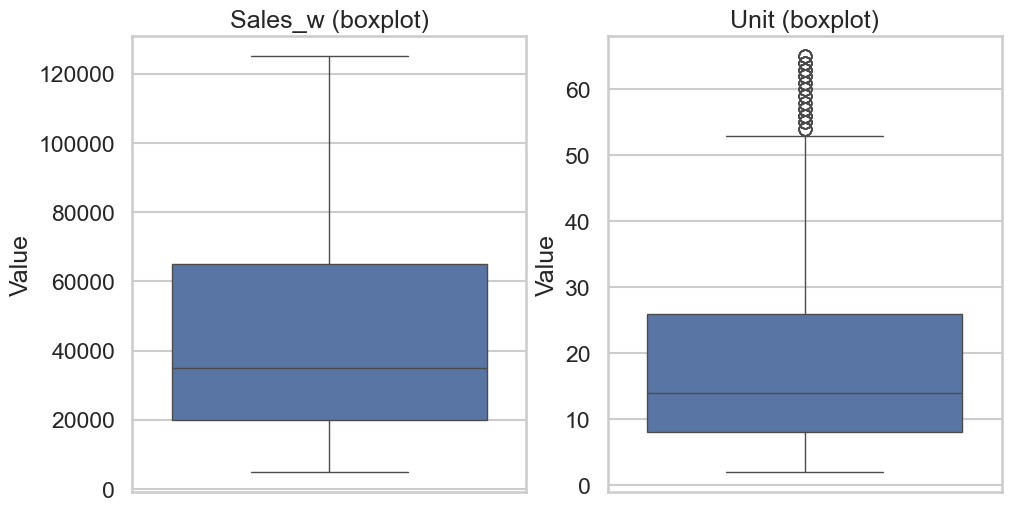

In [ ]:


value_col = "Sales_w" if "Sales_w" in data.columns else "Sales"
unit_col  = "Unit" if "Unit" in data.columns else "Unit"  

sales = pd.to_numeric(data[value_col], errors="coerce").dropna()
units = pd.to_numeric(data[unit_col],  errors="coerce").dropna()

sns.set_theme(context="talk", style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

sns.boxplot(y=sales, ax=axes[0])
axes[0].set_title(f"{value_col} (boxplot)")
axes[0].set_ylabel("Value")

sns.boxplot(y=units, ax=axes[1])
axes[1].set_title(f"{unit_col} (boxplot)")
axes[1].set_ylabel("Value")

plt.show()

### 2.2 State Analysis (Highest / Lowest Sales)

**Method**  
Group by `State` and sum revenue/units; sort by revenue.

**Why**  
Shows which states lead or lag in total sales, guiding budget allocation, targeted recovery programs, localized campaigns, and staffing/inventory decisions. Using monetary sums (preferably on winsorized `Sales_w`) preserves business meaning while limiting outlier distortion.



In [64]:
state_rank = (
    data.groupby("State", as_index=False)
        .agg(revenue=(value_col, "sum"),
             units=(unit_col, "sum"),
             rows=(value_col, "size"))
        .sort_values("revenue", ascending=False)
        .reset_index(drop=True)
)

top_states = state_rank.head(10)
bottom_states = state_rank.tail(10).sort_values("revenue", ascending=True)

print("Top states by revenue:")
print(top_states.to_string(index=False))

print("\nBottom states by revenue:")
print(bottom_states.to_string(index=False))


Top states by revenue:
State   revenue  units  rows
  VIC 102465000  42226  1080
  NSW  74970000  29988  1080
   SA  58857500  23543  1080
  QLD  33417500  13367  1080
  TAS  22760000   9104  1080
   NT  22580000   9032  1080
   WA  22152500   8861  1080

Bottom states by revenue:
State   revenue  units  rows
   WA  22152500   8861  1080
   NT  22580000   9032  1080
  TAS  22760000   9104  1080
  QLD  33417500  13367  1080
   SA  58857500  23543  1080
  NSW  74970000  29988  1080
  VIC 102465000  42226  1080


### 2.3 Demographic Group Analysis (Highest / Lowest Sales)

**Method**  
Group by `Group` and sum revenue/units; sort by revenue.  


**Why**  
Identifies which demographic segments (Kids, Women, Men, Seniors) lead or lag.


In [65]:
group_rank = (
    data.groupby("Group", as_index=False)
        .agg(revenue=(value_col, "sum"),
             units=(unit_col, "sum"),
             rows=(value_col, "size"))
        .sort_values("revenue", ascending=False)
        .reset_index(drop=True)
)

print("Groups ranked by revenue:")
print(group_rank.to_string(index=False))

print("\nGroup with highest sales:", group_rank.iloc[0]["Group"])
print("Group with lowest sales:", group_rank.iloc[-1]["Group"])


Groups ranked by revenue:
   Group  revenue  units  rows
     Men 85007500  34300  1890
   Women 84607500  34177  1890
    Kids 84450000  34029  1890
 Seniors 83137500  33615  1890

Group with highest sales:  Men
Group with lowest sales:  Seniors


### 2.4 Temporal Analysis (Daily / Weekly / Monthly / Quarterly)

**Method**  
If a date column is present, we aggregate revenue and units by calendar buckets using `pd.Grouper`.

**Why**  
Reveals trends, seasonality, peaks, and dips over the quarter—critical for planning campaigns and staffing.


In [ ]:
data = data.copy()
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")


WEEK_FREQ = "W-SUN"     
MONTH_FREQ = "ME"      
QUARTER_FREQ = "QE-DEC" 



weekly_total = (
    data.resample(WEEK_FREQ, on="Date")
        .agg(revenue=(value_col, "sum"), units=(unit_col, "sum"))
        .reset_index()
        .sort_values("Date")
)

monthly_total = (
    data.resample(MONTH_FREQ, on="Date")
        .agg(revenue=(value_col, "sum"), units=(unit_col, "sum"))
        .reset_index()
        .sort_values("Date")
)

quarterly_total = (
    data.resample(QUARTER_FREQ, on="Date")
        .agg(revenue=(value_col, "sum"), units=(unit_col, "sum"))
        .reset_index()
        .sort_values("Date")
)

print("Weekly totals (sample):")
print(weekly_total.head(8).to_string(index=False))
print("\nMonthly totals (sample):")
print(monthly_total.head(8).to_string(index=False))
print("\nQuarterly totals (sample):")
print(quarterly_total.head(8).to_string(index=False))




weekly_by_state = (
    data.set_index("Date")
        .groupby("State")
        .resample(WEEK_FREQ)
        .agg({value_col: "sum", unit_col: "sum"})
        .rename(columns={value_col: "revenue", unit_col: "units"})
        .reset_index()
        .sort_values(["State", "Date"])
)

monthly_by_state = (
    data.set_index("Date")
        .groupby("State")
        .resample(MONTH_FREQ)
        .agg({value_col: "sum", unit_col: "sum"})
        .rename(columns={value_col: "revenue", unit_col: "units"})
        .reset_index()
        .sort_values(["State", "Date"])
)

quarterly_by_state = (
    data.set_index("Date")
        .groupby("State")
        .resample(QUARTER_FREQ)
        .agg({value_col: "sum", unit_col: "sum"})
        .rename(columns={value_col: "revenue", unit_col: "units"})
        .reset_index()
        .sort_values(["State", "Date"])
)

print("\nWeekly by State (sample):")
print(weekly_by_state.head(8).to_string(index=False))
print("\nMonthly by State (sample):")
print(monthly_by_state.head(8).to_string(index=False))
print("\nQuarterly by State (sample):")
print(quarterly_by_state.head(8).to_string(index=False))


Weekly totals (sample):
      Date  revenue  units
2020-10-04 15045000   6018
2020-10-11 27002500  10801
2020-10-18 26640000  10656
2020-10-25 26815000  10726
2020-11-01 21807500   8723
2020-11-08 20865000   8346
2020-11-15 21172500   8469
2020-11-22 21112500   8445

Monthly totals (sample):
      Date   revenue  units
2020-10-31 114290000  45716
2020-11-30  90682500  36273
2020-12-31 132230000  54132

Quarterly totals (sample):
      Date   revenue  units
2020-12-31 337202500 136121

Weekly by State (sample):
State       Date  revenue  units
  NSW 2020-10-04  3382500   1353
  NSW 2020-10-11  5892500   2357
  NSW 2020-10-18  5717500   2287
  NSW 2020-10-25  5922500   2369
  NSW 2020-11-01  4822500   1929
  NSW 2020-11-08  4915000   1966
  NSW 2020-11-15  4957500   1983
  NSW 2020-11-22  4987500   1995

Monthly by State (sample):
State       Date  revenue  units
  NSW 2020-10-31 25007500  10003
  NSW 2020-11-30 21490000   8596
  NSW 2020-12-31 28472500  11389
   NT 2020-10-31  8222500  

## 3. Visualización (Dashboard S&M)


In [67]:

import matplotlib.dates as mdates
import matplotlib.ticker as mticker

### 3.1 Sales by State × Group (Kids, Women, Men, Seniors)

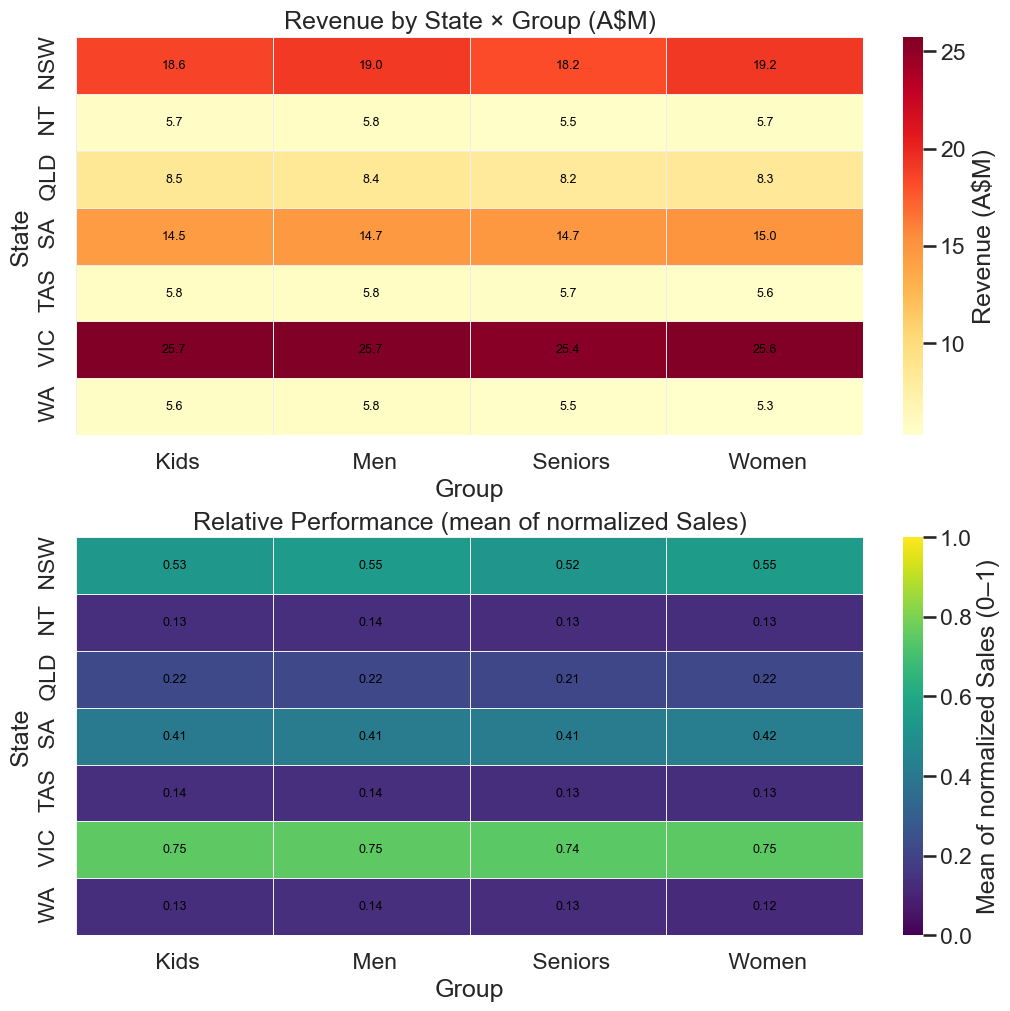

In [ ]:

sns.set_theme(context="talk", style="white")      
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"]   = "white"

value_col = "Sales_w" if "Sales_w" in data.columns else "Sales"
norm_col  = "Sales_w_norm" if "Sales_w_norm" in data.columns else None


pivot_abs = data.pivot_table(values=value_col, index="State", columns="Group",
                             aggfunc="sum", fill_value=0)
pivot_abs_m = pivot_abs / 1e6  

fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True)


ax = sns.heatmap(
    pivot_abs_m, ax=axes[0],
    cmap="YlOrRd",                
    linewidths=0.5, linecolor="#EEEEEE",
    annot=True, fmt=".1f",        
    annot_kws={"color": "black", "fontsize": 9},
    cbar_kws={"label": "Revenue (A$M)"}
)
axes[0].set_title("Revenue by State x Group (A$M)")
axes[0].set_xlabel("Group"); axes[0].set_ylabel("State")


if norm_col:
    pivot_rel = data.pivot_table(values=norm_col, index="State", columns="Group",
                                 aggfunc="mean", fill_value=0)
    ax = sns.heatmap(
        pivot_rel, ax=axes[1],
        cmap="viridis", vmin=0, vmax=1,  
        linewidths=0.5, linecolor="#EEEEEE",
        annot=True, fmt=".2f",
        annot_kws={"color": "black", "fontsize": 9},
        cbar_kws={"label": "Mean of normalized Sales (0–1)"}
    )
    axes[1].set_title("Relative Performance (mean of normalized Sales)")
    axes[1].set_xlabel("Group"); axes[1].set_ylabel("State")

plt.show()


### 3.2 Sales by Group × States

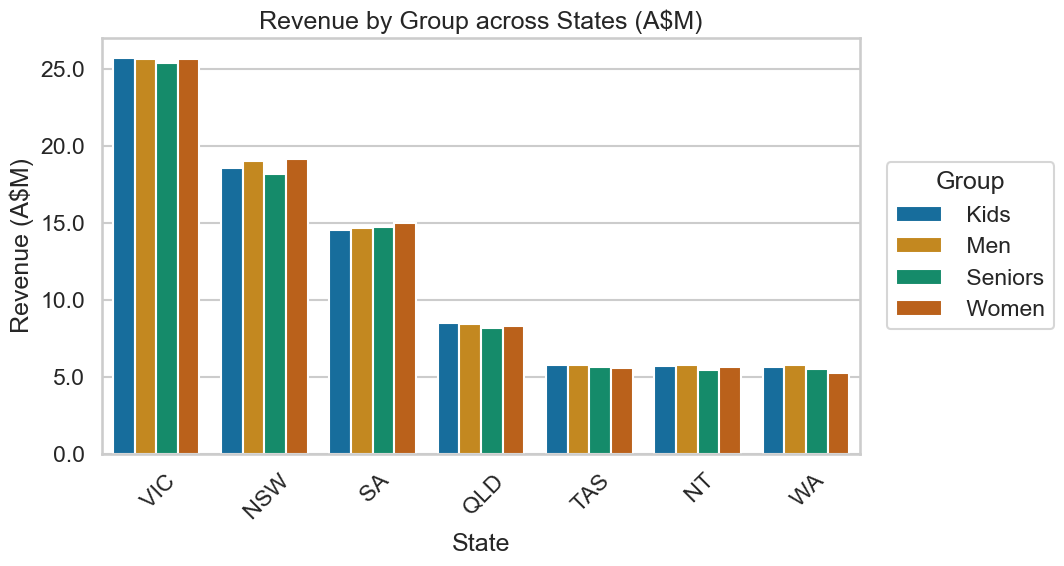

In [ ]:


sns.set_theme(context="talk", style="whitegrid")

value_col = "Sales_w" if "Sales_w" in data.columns else "Sales"

grp_state = (data.groupby(["State", "Group"], as_index=False)
               .agg(revenue=(value_col, "sum")))
grp_state["revenue_m"] = grp_state["revenue"] / 1e6  # A$ millions


order_states = (grp_state.groupby("State")["revenue_m"].sum()
                          .sort_values(ascending=False)
                          .index.tolist())


canonical = ["Kids", "Men", "Seniors", "Women"]
present = grp_state["Group"].unique().tolist()
order_groups = [g for g in canonical if g in present] or sorted(present)


colors = sns.color_palette("colorblind", n_colors=len(order_groups))
palette_map = dict(zip(order_groups, colors))

fig, ax = plt.subplots(figsize=(11, 6))
sns.barplot(
    data=grp_state, x="State", y="revenue_m",
    hue="Group", hue_order=order_groups,
    order=order_states, palette=palette_map, ax=ax
)

ax.set_title("Revenue by Group across States (A$M)")
ax.set_xlabel("State"); ax.set_ylabel("Revenue (A$M)")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))
plt.xticks(rotation=45)


ax.legend(title="Group", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)

plt.tight_layout()
plt.show()


### 3.3 Time of Day (Peaks and Valleys)

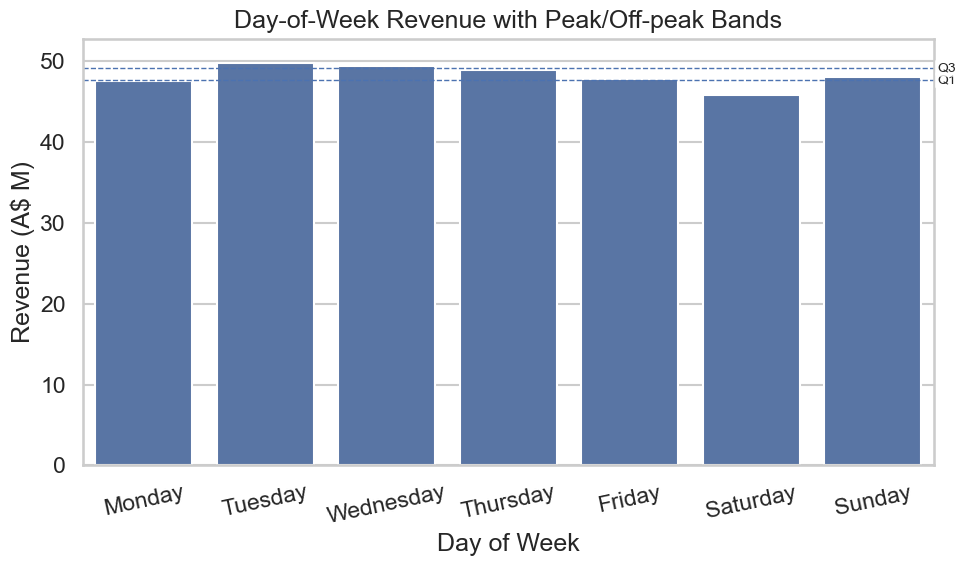

Peaks (>=Q3): ['Tuesday', 'Wednesday']
Off-peak (<=Q1): ['Monday', 'Saturday']
Spread (max - min): 3.89 (A$ M)


In [ ]:
import matplotlib.transforms as mtransforms


def day_of_week_profile(df: pd.DataFrame, date_col="Date", value_col=None, date_format=None):

    if value_col is None:
        for c in ("Sales_w","Sales","Revenue","Amount","Total"):
            if c in df.columns:
                value_col = c; break
    if value_col is None:
        raise ValueError("No revenue/sales column found.")

    s = df[date_col].astype(str).str.strip()
    if date_format:
        dt = pd.to_datetime(s, format=date_format, errors="coerce")
    else:
        for f in ["%Y-%m-%d","%d/%m/%Y","%m/%d/%Y","%d-%m-%Y","%Y/%m/%d"]:
            dt = pd.to_datetime(s, format=f, errors="coerce", cache=True)
            if dt.notna().mean() >= 0.9: break
    if dt.notna().sum() == 0:
        dt = s.apply(lambda x: pd.to_datetime(x, errors="coerce"))
    tmp = df.copy()
    tmp["_dt"] = dt
    tmp = tmp.dropna(subset=["_dt"])
    tmp["_date"] = tmp["_dt"].dt.normalize()
    tmp["weekday"] = tmp["_dt"].dt.day_name()
    daily = tmp.groupby(["_date","weekday"], as_index=False)[value_col].sum()
    by_wd = daily.groupby("weekday", as_index=False)[value_col].sum()
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    by_wd["weekday"] = pd.Categorical(by_wd["weekday"], categories=order, ordered=True)
    by_wd = by_wd.sort_values("weekday")

    y = by_wd[value_col]
    scale = 1e6 if y.max() >= 1e7 else 1.0
    by_wd["value"] = y / scale
    unit = " (A$ M)" if scale == 1e6 else " (A$)"
    return by_wd, unit

def plot_dow_pretty(by_wd: pd.DataFrame, unit_label: str):
    sns.set_theme(context="talk", style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))

    
    sns.barplot(data=by_wd, x="weekday", y="value", ax=ax)

    
    q1 = by_wd["value"].quantile(0.25)
    q3 = by_wd["value"].quantile(0.75)
    ax.axhline(q1, linestyle="--", linewidth=1)
    ax.axhline(q3, linestyle="--", linewidth=1)


    trans = mtransforms.blended_transform_factory(ax.transAxes, ax.transData)
    box = dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
    ax.text(1.005, q1, "Q1", transform=trans, va="center", ha="left", fontsize=10, bbox=box)
    ax.text(1.005, q3, "Q3", transform=trans, va="center", ha="left", fontsize=10, bbox=box)


    ax.set_ylim(0, max(by_wd["value"].max(), q3) * 1.06)

    ax.set_title("Day-of-Week Revenue with Peak/Off-peak Bands", pad=8)
    ax.set_xlabel("Day of Week"); ax.set_ylabel("Revenue" + unit_label)
    plt.xticks(rotation=12)
    plt.tight_layout(); plt.show()

    return q1, q3


by_wd, unit = day_of_week_profile(data, date_col="Date")   
q1, q3 = plot_dow_pretty(by_wd, unit)


peaks = by_wd.loc[by_wd["value"] >= q3, "weekday"].tolist()
offp  = by_wd.loc[by_wd["value"] <= q1, "weekday"].tolist()
spread = by_wd["value"].max() - by_wd["value"].min()
print("Peaks (>=Q3):", peaks)
print("Off-peak (<=Q1):", offp)
print(f"Spread (max - min): {spread:.2f}{unit}")

### 3.4 Daily, Weekly, Monthly, and Quarterly Views

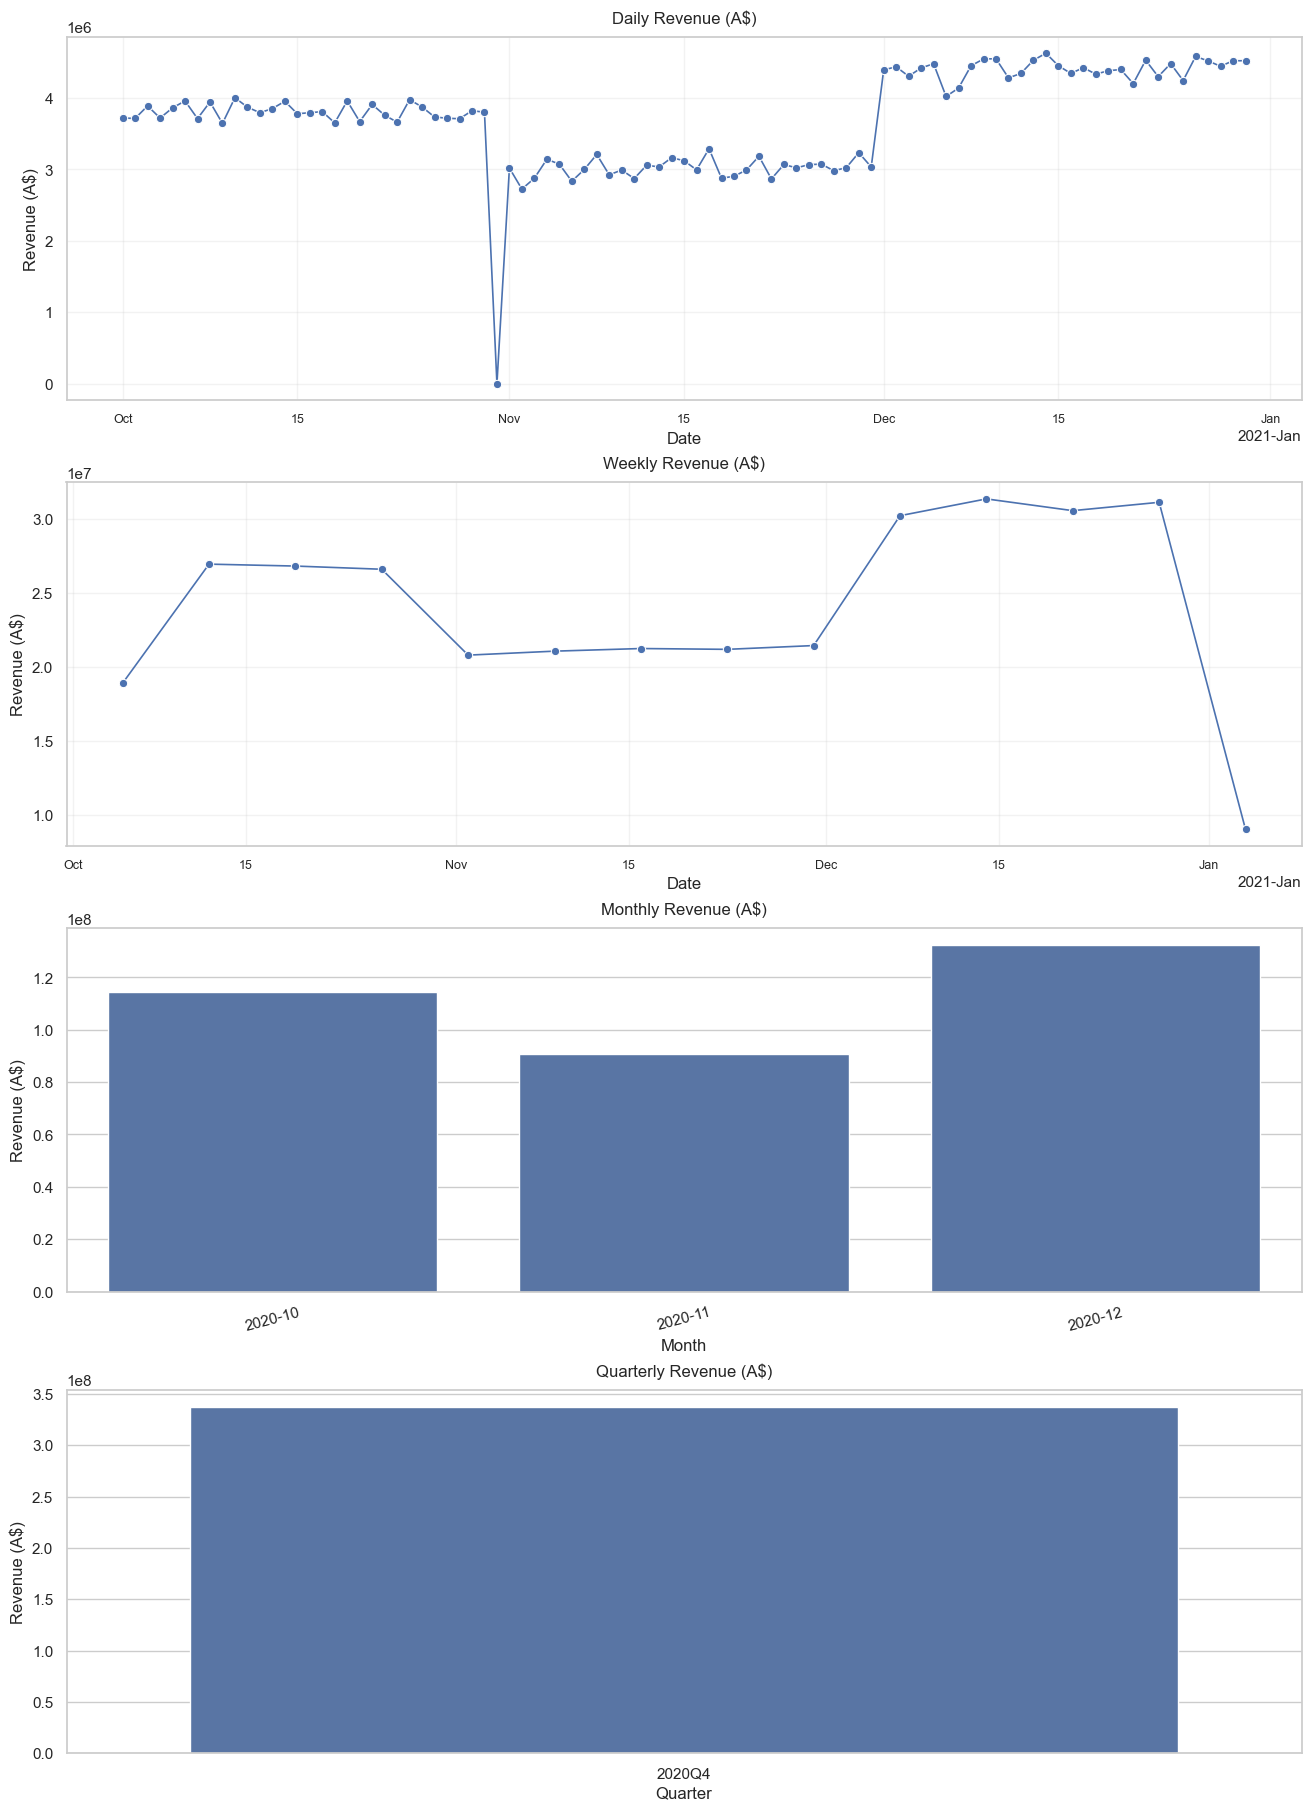

In [ ]:


value_col = "Sales_w" if "Sales_w" in data.columns else "Sales"

def rollup_total(df, freq_key):
    freq_map = {"D": "D", "W": "W-MON", "M": "ME", "Q": "QE-DEC"}
    rule = freq_map[freq_key]  

    out = (df.assign(Date=pd.to_datetime(df["Date"], errors="coerce"))
             .dropna(subset=["Date"])
             .set_index("Date")
             .resample(rule, label="right", closed="right")
             .agg(revenue=(value_col, "sum"))
             .reset_index()
             .sort_values("Date"))
    return out

def format_time_axis(ax, dates):
    dates = pd.to_datetime(pd.Series(dates)).dropna()
    if dates.empty: 
        return
    locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.tick_params(axis="x", labelsize=9)
    ax.grid(True, alpha=0.25)

daily     = rollup_total(data, "D")
weekly    = rollup_total(data, "W")
monthly   = rollup_total(data, "M")      
quarterly = rollup_total(data, "Q")     


monthly_lab   = monthly.assign(Period=monthly["Date"].dt.to_period("M").astype(str))
quarterly_lab = quarterly.assign(Period=quarterly["Date"].dt.to_period("Q").astype(str))


sns.set_theme(context="notebook", style="whitegrid")
fig, axes = plt.subplots(4, 1, figsize=(13, 18), constrained_layout=True)

ax = axes[0]
sns.lineplot(data=daily, x="Date", y="revenue", marker="o", linewidth=1.2, ax=ax)
ax.set_title("Daily Revenue (A$)", pad=10); ax.set_xlabel("Date"); ax.set_ylabel("Revenue (A$)")
format_time_axis(ax, daily["Date"])

ax = axes[1]
sns.lineplot(data=weekly, x="Date", y="revenue", marker="o", linewidth=1.2, ax=ax)
ax.set_title("Weekly Revenue (A$)", pad=10); ax.set_xlabel("Date"); ax.set_ylabel("Revenue (A$)")
format_time_axis(ax, weekly["Date"])

ax = axes[2]
sns.barplot(data=monthly_lab, x="Period", y="revenue", ax=ax)
ax.set_title("Monthly Revenue (A$)", pad=10); ax.set_xlabel("Month"); ax.set_ylabel("Revenue (A$)")
ax.tick_params(axis="x", labelrotation=15)

ax = axes[3]
sns.barplot(data=quarterly_lab, x="Period", y="revenue", ax=ax)
ax.set_title("Quarterly Revenue (A$)", pad=10); ax.set_xlabel("Quarter"); ax.set_ylabel("Revenue (A$)")

plt.show()


Daily revenue is broadly stable (~3.6–4.6M) with a sharp early-November dip (likely a refund/ETL issue) and a clear step-up in early December; weekly aggregates smooth noise and confirm a steady floor with acceleration in December (beware the last week if it’s partial); monthly bars show a V-shape—November strong, December dragged by the dip/short period—while the quarterly bar cleanly summarizes Q4 and matches the monthly totals. We used pandas.resample for calendar-aware, reproducible rollups (day/week/month/quarter) and Seaborn/Matplotlib for clean, readable time axes and the right mark types—lines for continuous daily/weekly series, bars for discrete monthly/quarterly points.